<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/4.Bike/Bike_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.EDA

In [483]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [484]:
from google.colab import drive
drive.mount('/content/gdrive')
train_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/bike_train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/bike_test.csv')
datetime=test_df['datetime']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [485]:
df=pd.concat([train_df,test_df],axis=0,ignore_index=True)
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0


##1)Basic statistics

In [486]:
df.info() #null at casual,registered,count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [487]:
test_df.info() #test_df has no registered,casual data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [488]:
df.describe() #outlier can be spotted here too

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


##2)Dropping&Creating features



In [489]:
df.drop(['holiday','casual','registered'],axis=1,inplace=True) #columns have meanings 

In [490]:
df.datetime=df.datetime.apply(pd.to_datetime) #datetime is a dtype in pandas #lambda is for numbers
df['year']=df.datetime.apply(lambda x:x.year) #each function extracts data from datetime object #names like year,month can't be written in df.year like form
df['month']=df.datetime.apply(lambda x:x.month)
df['day']=df.datetime.apply(lambda x:x.day)
df['hour']=df.datetime.apply(lambda x:x.hour)
df.drop(['datetime'],axis=1,inplace=True)
df.head(3)

,season,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,1,9.84,14.395,81,0.0,16.0,2011,1,1,0
1,1,0,1,9.02,13.635,80,0.0,40.0,2011,1,1,1
2,1,0,1,9.02,13.635,80,0.0,32.0,2011,1,1,2


##3)Encoding

In [491]:
df=pd.get_dummies(df,columns=['workingday','hour','weather','month']) #makes each categorical value into a column(seperation&restore balance of importance)

#2.Preprocessing(with Visualization)

##1)Null filling

##2)Scaling&Outlier removal

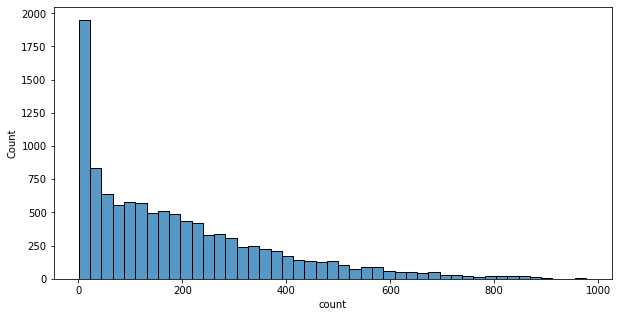

In [493]:
f=plt.figure(figsize=(10,5)) #ax is for subplots 
sns.histplot(data=df,x='count') #so many values are better shown in hist

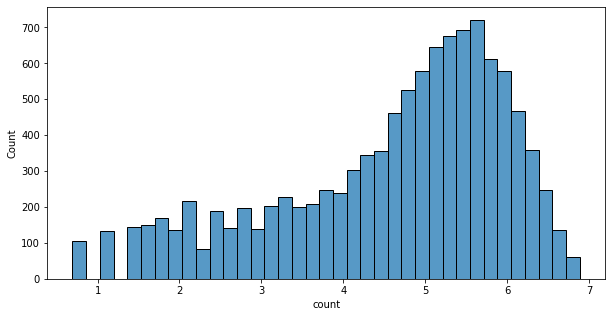

In [494]:
df['count']=np.log1p(df['count'])
f=plt.figure(figsize=(10,5)) 
sns.histplot(data=df,x='count')

#3.Modeling

In [495]:
train_df=df.loc[df['count'].isna()==False] #comparison with True in condition needs two =
test_df=df.loc[df['count'].isna()==True]
target_df=train_df['count']
feature_df=train_df.drop('count',axis=1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6493 entries, 10886 to 17378
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        6493 non-null   int64  
 1   temp          6493 non-null   float64
 2   atemp         6493 non-null   float64
 3   humidity      6493 non-null   int64  
 4   windspeed     6493 non-null   float64
 5   count         0 non-null      float64
 6   year          6493 non-null   int64  
 7   day           6493 non-null   int64  
 8   workingday_0  6493 non-null   uint8  
 9   workingday_1  6493 non-null   uint8  
 10  hour_0        6493 non-null   uint8  
 11  hour_1        6493 non-null   uint8  
 12  hour_2        6493 non-null   uint8  
 13  hour_3        6493 non-null   uint8  
 14  hour_4        6493 non-null   uint8  
 15  hour_5        6493 non-null   uint8  
 16  hour_6        6493 non-null   uint8  
 17  hour_7        6493 non-null   uint8  
 18  hour_8        6493 non-

In [496]:
def get_eval(real,pred): #make RMSLE(start from L to R)
  squared_error=(np.log1p(real)-np.log1p(pred))**2
  rmsle=np.sqrt(np.mean(squared_error))
  rmse=np.sqrt(mean_squared_error(real,pred)) #prefer rmse to normal mse
  mae=mean_absolute_error(real,pred)
  print('RMSLE:{0:.4f} / RMSE:{1:.4f} / MAE:{2:.4f}'.format(rmsle,rmse,mae))

In [497]:
X_train,X_test,y_train,y_test=train_test_split(feature_df,target_df,test_size=0.1,random_state=0)

In [498]:
lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=(lr_reg.predict(X_test)) #must after logscaling
get_eval(y_test,pred)

RMSLE:0.1527 / RMSE:0.6183 / MAE:0.4627


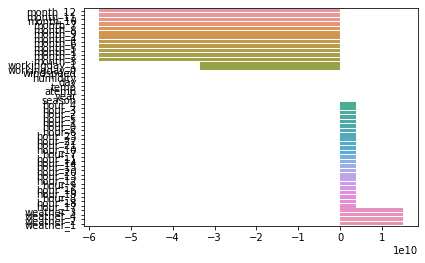

In [499]:
coef=pd.Series(lr_reg.coef_,index=feature_df.columns).sort_values() #coefficient value imply importance
sns.barplot(x=coef,y=coef.index) #encoded categorical values need onehotencoding

In [500]:
rf_reg=RandomForestRegressor(n_estimators=1000)
xgb_reg=XGBRegressor(n_estimators=1000)
lgbm_reg=LGBMRegressor(n_estimators=1000)

In [501]:
rf_reg.fit(X_train,y_train)
pred2=rf_reg.predict(X_test)
get_eval(y_test,pred2)

RMSLE:0.1017 / RMSE:0.3737 / MAE:0.2550


In [502]:
xgb_reg.fit(X_train,y_train)
pred3=xgb_reg.predict(X_test)
get_eval(y_test,pred3)

[14:58:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:0.0950 / RMSE:0.3458 / MAE:0.2405


In [503]:
lgbm_reg.fit(X_train,y_train)
pred4=lgbm_reg.predict(X_test)
get_eval(y_test,pred4)

RMSLE:0.0925 / RMSE:0.3373 / MAE:0.2318


In [504]:
vo_reg=VotingRegressor([('lr',lr_reg),('rf',rf_reg),('xgb',xgb_reg),('lgbm',lgbm_reg)]) #always softvoting #does not fit twice after past fit
vo_reg.fit(X_train,y_train)
pred1=vo_reg.predict(X_test)
get_eval(y_test,pred1)

[14:59:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE:0.1011 / RMSE:0.3699 / MAE:0.2635


#1)Uploading

In [508]:
pred=vo_reg.predict(test_df)
realpred=pd.DataFrame(pred,columns='count')
submit_df=pd.DataFrame({'datetime':datetime,'count':realpred['count']}) 
submit_df.head(3)

TypeError: ignored

In [ ]:
submit_df.to_csv('/content/gdrive/MyDrive/Dataset/Lutris_Bike.csv', index = False) 

#2)Feedback
baseline : fine for a start<br>
RMSLE:0.5590 / RMSE:33.3667 / MAE:23.2740<br>
RuntimeWarning: invalid value encountered in log1p
logscaling : much better with no expm1?!!(about prediction)<br>
RMSLE:0.1874 / RMSE:0.7332 / MAE:0.5615<br>
onehotencoding : still improvement<br>
RMSLE:0.1360 / RMSE:0.5033 / MAE:0.3489<br>
voting regressor<br>
RMSLE:0.0502 / RMSE:0.1598 / MAE:0.1118

outlier windspeed<br>

#3)Afterwords
regression problems are mostly time series analysis anyways